In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("crime.csv", encoding='utf-8', low_memory=False)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
df = df.dropna(subset=['Location Description'])

In [5]:
# 1. 사용할 Feature 선택
features = [
    'Year', 'Month', 'Primary Type',
    'Description', 'Community Area',
    'Latitude', 'Longitude', 'Offense Level Median',
    'Dist_to_Nearest_HighRisk','min_distance_to_police',
    'Location Description'

]
target = 'Arrest'

In [6]:
#  범주형 컬럼 숫자로 변환 (Label Encoding)
label_cols = ['Primary Type', 'Description', 'Location Description']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

In [7]:
# 학습 데이터 분리 (Train/Test)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
# 4. 모델 학습 (랜덤 포레스트)
model = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [9]:
# 예측
y_pred = model.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93   1848379
        True       0.87      0.67      0.76    630467

    accuracy                           0.89   2478846
   macro avg       0.88      0.82      0.84   2478846
weighted avg       0.89      0.89      0.89   2478846



In [23]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from folium.features import GeoJsonTooltip

# 1. 파일 불러오기 (시카고 커뮤니티 영역)
df_geo = pd.read_csv("CommAreas_20250408.csv", encoding='utf-8', low_memory=False)

# 2. Community Area 이름 매핑
df_geo = df_geo[['AREA_NUMBE', 'COMMUNITY', 'the_geom']].drop_duplicates()
df_geo.columns = ['Community Area', 'Community Area Name', 'geometry_str']

# 3. geometry 문자열을 shapely Polygon으로 변환
df_geo['geometry'] = df_geo['geometry_str'].apply(wkt.loads)
gdf_geo = gpd.GeoDataFrame(df_geo, geometry='geometry', crs='EPSG:4326')

# 4. Community Area 번호를 문자열로 통일
gdf_geo['Community Area'] = gdf_geo['Community Area'].astype(str)
X_test['Community Area'] = X_test['Community Area'].astype(float).astype(int).astype(str)
# 체포 확률 예측 열이 이미 있으면 삭제 후 다시 예측
X_test_pred = X_test.copy()

if 'Arrest_Prob' in X_test_pred.columns:
    X_test_pred.drop(columns=['Arrest_Prob'], inplace=True)

# 예측 확률 다시 계산
X_test_pred['Arrest_Prob'] = model.predict_proba(X_test_pred[features])[:, 1]


# 6. 지역별 평균 체포 확률
# ✅ 올바른 코드
area_avg = X_test_pred.groupby('Community Area')['Arrest_Prob'].mean().reset_index()

# 7. 병합 (지리정보와 예측 확률)
gdf = gdf_geo.merge(area_avg, on='Community Area', how='left')

# 8. Choropleth 스타일 함수
cmap = cm.get_cmap('Reds')
norm = mcolors.Normalize(vmin=0, vmax=1)

def style_function(feature):
    prob = feature['properties'].get('Arrest_Prob')
    if prob is None or pd.isna(prob):
        return {
            'fillOpacity': 0.1,
            'color': 'lightgrey',
            'fillColor': 'lightgrey',
            'weight': 0.5
        }
    if prob > 0.38:
        color = '#6b0700'
    elif prob > 0.34:
        color = '#8f0a00'
    elif prob > 0.30:
        color = '#d60e00'
    elif prob > 0.26:
        color = '#ff1b0a'
    elif prob > 0.22:
        color = '#ff4a3d'
    elif prob > 0.18:
        color = '#ff756b'
    elif prob > 0.14:
        color = '#ffa9a3'
    else:
        color = '#ffeceb'

    return {
        'fillOpacity': 0.8,
        'weight': 1,
        'fillColor': color,
        'color': 'black'
    }


# 9. Folium 지도 생성
m = folium.Map(location=[41.87, -87.62], zoom_start=10,tiles="cartodbpositron")

folium.GeoJson(
    gdf.to_json(),
    name="Community Area 체포 확률 (Test Set)",
    style_function=style_function,
    tooltip=GeoJsonTooltip(
        fields=["Community Area Name", "Arrest_Prob"],
        aliases=["지역 이름", "예측 체포확률"],
        localize=True,
        sticky=False,
        labels=True
    )
).add_to(m)




# 10. 지도 저장
m.save("Community_Area_Prediction_Map_testset.html")


C:\Users\qhwhr\AppData\Local\Temp\ipykernel_6496\979168682.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [33]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from folium.features import GeoJsonTooltip

# 1. 파일 불러오기
df_geo = pd.read_csv("CommAreas_20250408.csv", encoding='utf-8', low_memory=False)
df = pd.read_csv("df_sample.csv")  # df도 다시 불러온다고 가정

# 2. Community Area 이름 매핑
df_geo = df_geo[['AREA_NUMBE', 'COMMUNITY', 'the_geom']].drop_duplicates()
df_geo.columns = ['Community Area', 'Community Area Name', 'geometry_str']

# 3. geometry 변환 → GeoDataFrame
df_geo['geometry'] = df_geo['geometry_str'].apply(wkt.loads)
gdf_geo = gpd.GeoDataFrame(df_geo, geometry='geometry', crs='EPSG:4326')

# 4. Community Area 번호 타입 통일
gdf_geo['Community Area'] = gdf_geo['Community Area'].astype(str)
df['Community Area'] = df['Community Area'].astype(float).astype(int).astype(str)

# 5. 실제 체포율 계산
actual_rate = df.groupby('Community Area')['Arrest'].mean().reset_index()
actual_rate.columns = ['Community Area', 'Actual_Arrest_Rate']

# 6. 병합
gdf_actual = gdf_geo.merge(actual_rate, on='Community Area', how='left')

# 7. Choropleth 스타일 함수
cmap = cm.get_cmap('Reds')
norm = mcolors.Normalize(vmin=0, vmax=1)

def style_function_actual(feature):
    rate = feature['properties'].get('Actual_Arrest_Rate')
    if rate is None or pd.isna(rate):
        return {
            'fillOpacity': 0.1,
            'color': 'lightgrey',
            'fillColor': 'lightgrey',
            'weight': 0.5
        }
    if rate > 0.38:
        color = '#6b0700'
    elif rate > 0.34:
        color = '#8f0a00'
    elif rate > 0.30:
        color = '#d60e00'
    elif rate > 0.26:
        color = '#ff1b0a'
    elif rate > 0.22:
        color = '#ff4a3d'
    elif rate > 0.18:
        color = '#ff756b'
    elif rate > 0.14:
        color = '#ffa9a3'
    else:
        color = '#ffeceb'

    return {
        'fillOpacity': 0.8,
        'weight': 1,
        'fillColor': color,
        'color': 'black'
    }
# 8. Folium 지도 생성
m = folium.Map(location=[41.87, -87.62], zoom_start=10,tiles="cartodbpositron")

folium.GeoJson(
    gdf_actual.to_json(),
    name="실제 체포율 Choropleth",
    style_function=style_function_actual,
    tooltip=GeoJsonTooltip(
        fields=["Community Area Name", "Actual_Arrest_Rate"],
        aliases=["지역 이름", "실제 체포율"],
        localize=True,
        sticky=False,
        labels=True
    )
).add_to(m)

# 9. 저장
m.save("Community_Area_Actual_Arrest_Map.html")


C:\Users\qhwhr\AppData\Local\Temp\ipykernel_6496\3586946979.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [36]:
# df: 사건 단위 원본 데이터 (Arrest)
# gdf: 지리정보 포함 + 예측 확률 집계된 GeoDataFrame
# actual 체포율 구하기
actual_rate = df.groupby('Community Area')['Arrest'].mean().reset_index()
actual_rate.columns = ['Community Area', 'Actual_Arrest_Rate']

# 병합 (예측 평균 + 실제 체포율)
gdf = gdf.merge(actual_rate, on='Community Area', how='left')

# 예측과 실제의 차이 (Gap)
gdf['Gap'] = gdf['Arrest_Prob'] - gdf['Actual_Arrest_Rate']


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = gdf['Actual_Arrest_Rate']
y_pred = gdf['Arrest_Prob']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


MAE: 0.0179, RMSE: 0.0216, R²: 0.8930


C:\Users\qhwhr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
# 오차 기준 정렬
top_over = gdf.sort_values('Gap', ascending=False).head(3)
top_under = gdf.sort_values('Gap', ascending=True).head(3)

print("과대 예측 지역 (예측 > 실제):")
print(top_over[['Community Area Name', 'Arrest_Prob', 'Actual_Arrest_Rate', 'Gap']])

print("\n과소 예측 지역 (예측 < 실제):")
print(top_under[['Community Area Name', 'Arrest_Prob', 'Actual_Arrest_Rate', 'Gap']])


과대 예측 지역 (예측 > 실제):
   Community Area Name  Arrest_Prob  Actual_Arrest_Rate       Gap
1              OAKLAND     0.202049            0.155340  0.046709
5       LINCOLN SQUARE     0.183014            0.136816  0.046198
48             PULLMAN     0.234628            0.192661  0.041967

과소 예측 지역 (예측 < 실제):
   Community Area Name  Arrest_Prob  Actual_Arrest_Rate       Gap
43       MCKINLEY PARK     0.232924            0.292079 -0.059155
70             BEVERLY     0.141177            0.175758 -0.034580
21            AVONDALE     0.200344            0.234414 -0.034070


In [39]:
def style_gap(feature):
    gap = feature['properties'].get('Gap')
    if gap is None or pd.isna(gap):
        return {'fillOpacity': 0.1, 'color': 'lightgrey', 'fillColor': 'lightgrey', 'weight': 0.5}

    # 색상: 과대(+): 빨강, 과소(-): 파랑
    if gap > 0.05:
        color = '#b30000'  # 과대 예측
    elif gap > 0.02:
        color = '#fc9272'
    elif gap > -0.02:
        color = '#fee0d2'
    elif gap > -0.05:
        color = '#deebf7'
    else:
        color = '#3182bd'  # 과소 예측

    return {
        'fillOpacity': 0.8,
        'weight': 1,
        'fillColor': color,
        'color': 'black'
    }

# 지도 생성
m_gap = folium.Map(location=[41.87, -87.62], zoom_start=10, tiles="cartodbpositron")

folium.GeoJson(
    gdf.to_json(),
    name="예측 - 실제 체포율 Gap",
    style_function=style_gap,
    tooltip=GeoJsonTooltip(
        fields=["Community Area Name", "Arrest_Prob", "Actual_Arrest_Rate", "Gap"],
        aliases=["지역", "예측값", "실제값", "차이(Gap)"],
        localize=True,
        sticky=False,
        labels=True
    )
).add_to(m_gap)

m_gap.save("Community_Area_Prediction_Gap_Map.html")


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE  # ✅ 추가
df = df.dropna(subset=['Location Description'])

# Feature 및 Target 설정
features = [
    'Year', 'Month', 'Primary Type',
    'Description', 'Community Area',
    'Latitude', 'Longitude', 'Offense Level Median',
    'Dist_to_Nearest_HighRisk','min_distance_to_police',
    'Location Description'
]
target = 'Arrest'

# Label Encoding (범주형 변수)
label_cols = ['Primary Type', 'Description', 'Location Description']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# 학습 데이터 분리
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ✅ SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.90      0.93      0.92   1848379
        True       0.78      0.71      0.74    630467

    accuracy                           0.88   2478846
   macro avg       0.84      0.82      0.83   2478846
weighted avg       0.87      0.88      0.87   2478846



In [ ]:
df = pd.read_csv("crime.csv", encoding='utf-8', low_memory=False)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
df = df.dropna(subset=['Location Description'])
# 1. 사용할 Feature 선택
features = [
    'Year', 'Month', 'Primary Type',
    'Description', 'Community Area',
    'Latitude', 'Longitude', 'Offense Level Median',
    'Dist_to_Nearest_HighRisk','min_distance_to_police',
    'Location Description'

]
target = 'Arrest'
#  범주형 컬럼 숫자로 변환 (Label Encoding)
label_cols = ['Primary Type', 'Description', 'Location Description']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le
# 학습 데이터 분리 (Train/Test)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# 4. 모델 학습 (랜덤 포레스트)
model = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
model.fit(X_train, y_train)
# 예측
y_pred = model.predict(X_test)

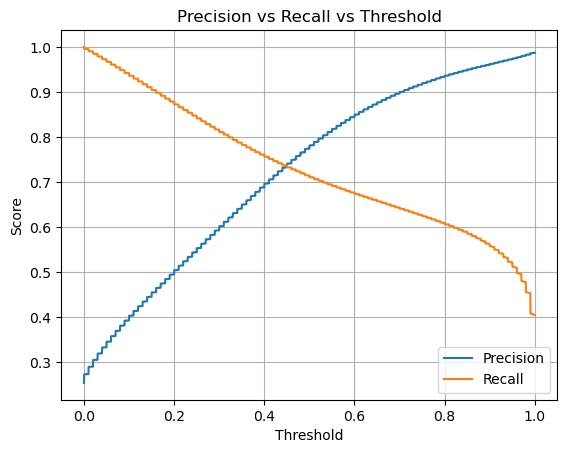

In [4]:
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt

# 1. 확률 예측
y_proba = model.predict_proba(X_test)[:, 1]  # True 클래스 확률

# 2. Precision-Recall 곡선 계산
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 3. 그래프 시각화
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0

for thresh in thresholds:
    preds = (y_proba >= thresh).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"⭐ Best Threshold: {best_thresh:.4f}, Best F1-score: {best_f1:.4f}")



KeyboardInterrupt



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE  # ✅ 추가
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = df.dropna(subset=['Location Description'])

# Feature 및 Target 설정
features = [
    'Year', 'Month', 'Primary Type',
    'Description', 'Community Area',
    'Latitude', 'Longitude', 'Offense Level Median',
    'Dist_to_Nearest_HighRisk','min_distance_to_police',
    'Location Description'
]
target = 'Arrest'

# Label Encoding (범주형 변수)
label_cols = ['Primary Type', 'Description', 'Location Description']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# 학습 데이터 분리
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ✅ SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Base 모델 정의
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# 3. 메타 모델 (최종 조합 판단)
meta_model = LogisticRegression()

# 4. StackingClassifier 구성
stack_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
    final_estimator=meta_model,
    passthrough=True,  # 원래 feature도 함께 메타모델에 전달
    n_jobs=-1
)

# 5. 학습 (SMOTE된 데이터로)
stack_model.fit(X_train_res, y_train_res)

# 6. 예측 및 평가
y_pred_stack = stack_model.predict(X_test)

print("📊 StackingClassifier 결과")
print(classification_report(y_test, y_pred_stack))


In [ ]:
# 단일 모델 성능 비교용 (이미 학습했다면 재학습 안 해도 됨)
models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} 결과")
    print(classification_report(y_test, y_pred))


In [35]:
gdf_diff = gdf_pred.merge(gdf_actual[['Community Area', 'Actual_Arrest_Rate']], on='Community Area')
gdf_diff['Gap'] = gdf_diff['Arrest_Prob'] - gdf_diff['Actual_Arrest_Rate']


NameError: name 'gdf_pred' is not defined

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 병합된 데이터프레임에 예측값 + 실제값이 모두 있다고 가정
# (예: gdf_pred_actual에 'Arrest_Prob', 'Actual_Arrest_Rate' 모두 존재)
y_true = gdf_pred['Actual_Arrest_Rate']
y_pred = gdf_pred['Arrest_Prob']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False → RMSE
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


NameError: name 'gdf_pred' is not defined